Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Connor McDonald"
StudentNumber = "u16040725"

---

# MIT 804 2021: Homework 3, part 3 [15 points]
## Genetic Algorithm and the travelling salesman problem

**You will learn how to:**
- Create a genetic algorithm
- Solve the travelling salesman problem

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1 The Travelling Salesman Problem


For this problem, we will first initialise the cities in our travelling salesman problem.

In [3]:
def initialise_city(num_dim, limit = 100):
    X = np.random.randint(0,limit,size=num_dim)
    return X

def initialise_cities(num_cities):
    cities = []
    for i in range(num_cities):
        cities.append(initialise_city(2))
    return cities
num_cities = 5
cities = initialise_cities(num_cities)
print("City Positions: ", cities)

City Positions:  [array([ 8, 94]), array([44, 12]), array([71, 59]), array([19, 42]), array([24, 71])]


### 1.1 Distance between ordered cities [5 points]

Given a visit order (the order cities should be visited) calculate the straight line distance between the cities. The easiest way, given two points $X$ and $Y$, calculate the square distance (euclidean distnce) between two points.

$d(X,Y) = \sqrt{(X_1-Y_1)^2 + (X_2-Y_2)^2}$

In the distance function, you must calciulate the distance between the cities in visit order.

So if the visit order is [3, 2, 1, 0], it means we start at city 3, then move to city 2 and then move to city 1. So the distances will be the distance between city 3 and city 2 added to the distances between city 2 and city 1 and then added to the distance between city 1 and city 0.

In [4]:
def distance_function(cities, visit_order):
    distance = 0.0
    def euclid(p1, p2):
        d = 0 
        for i in range(0,2):
            d += (p1[i] - p2[i])**2
        return np.sqrt(d)
    for i in range(1, len(visit_order)):
        distance += euclid(cities[visit_order[i]], cities[visit_order[i-1]])
    return -1.0*distance

In [5]:
visit_order = [0, 1, 2, 3, 4]
cities_simple = np.array([[0,0],[1,1],[2,2],[3,3],[4,4]])
dist = distance_function(cities_simple, visit_order)
assert dist == -4.0*np.sqrt(2)

## Lets plot the cities and a random path between them

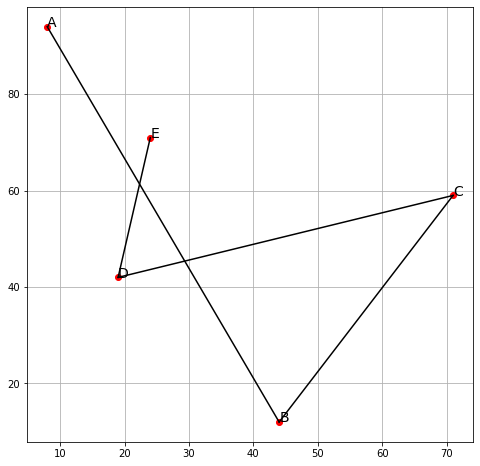

In [6]:
plt.figure(figsize=(8,8)) # Set the figure size
city_list = ['A','B','C','D','E']
x_axis = np.array(cities)[:,0]
y_axis = np.array(cities)[:,1]
plt.scatter(x_axis,y_axis,color = 'r')
plt.grid()
for i, txt in enumerate(city_list):
    plt.annotate(txt, (x_axis[i], y_axis[i]), size = 14)

for j in range(len(visit_order)-1):
    plt.plot(x_axis[[visit_order[j],visit_order[j+1]]],y_axis[[visit_order[j],visit_order[j+1]]], color = 'k')

## 2 Genetic Algorithm


### 2.1 Chromosome and populaton [2 points]
For this problem, we will first initialise a chromosome. To make it easy, the chromosome will be the order in which we visit the cities. So if we have 4 cities. 

Chromosome **[0,2,3,1]** will mean we start with city 0, then move to city 2, then city 3 and finally city 1. 

Hint: use np.random.permutation.

In [7]:
def initialise_chromosome(chromosome_size):
    chromosome = np.random.permutation(np.arange(0,chromosome_size,1))
    return chromosome
def initialise_population(population_size, chromosome_size):
    population = []
    for i in range(0, population_size):
        population.append(initialise_chromosome(chromosome_size))
#     raise NotImplementedError()
    return population

In [8]:
chromosome = initialise_chromosome(5)
assert len(chromosome) == 5
population = initialise_population(10,6)
assert len(population[0]) == 6
assert len(population) == 10

### 2.2 Calculate fitness

Calculate the fitness, when you have an ordering of visits.

In [9]:
def calculate_fitness(population, cities,  fitness_function):
    fitness_list = []
    for i in population:
        fitness_list.append(fitness_function(cities, i))
    return fitness_list

In [10]:
cities = np.array([[0,0],[1,1],[1,2]])
population = [[0,1,2],[0,2,1]]
fitness_list = calculate_fitness(population, cities, distance_function)
assert len(fitness_list) == 2
assert fitness_list[0] == -2.414213562373095
assert fitness_list[1] == -3.23606797749979

### 2.3 Selection. Pairing, Crossover and Mutation

This is were the magic happens. You will be giving the selection and pairing code. You must implement the child generation and mutation code.

In [11]:
def selection(population, fitness_list):
    ## Select the top half of the best of the population
    population = np.array(population)
    sorted_indices = np.argsort(fitness_list)
    selection_point = int(1+ len(fitness_list)/2)
    
    # Randomply permute this top half of the poulation
    indices = np.random.choice(sorted_indices[:selection_point], len(population))
    best_population = population[indices]
    return best_population

def pairing(selected_population):
    ## pair up parents that will be used to reproduce
    count = 0
    pairs = []
    while count < len(selected_population)-1:
        index = count
        pairs.append([selected_population[index],selected_population[index+1]])
        count +=2
    return pairs

### 2.3.1 Create child, reproduce [4 points]

You must implement the child generation. Given that the chromosomes here have to be ordered, you cannot simply do a cross-over as it might result in an invalid visit order (The same city listed more than once). To make it possible, you must implement a cross over that takes:

* a section of a chromosome from **parent a** (choose a random start and end point). For example starting with gene 2 up to gene 5 of **parent a**,
* and then fills in the rest of the chromosome with an ordered list from **parent b**
* without repeating the genes that we got from **parent a**.

An example is shown below

**Step 1:**

Parent A - [3, 2, 1, 4, 0, 5]
Parent B - [1, 3, 2, 5, 0, 4]

**Step 2:** Choose start and end point in Parent A

Parent A - [ x, x, **1, 4, 0**, x]

**Step 3:** Create child starting with *Parent A* and then fill with the missing chromosomes (in sequence) from *Parent B*

Parent B: [x, **3, 2, 5**, x, x]

Finally 

Child - [1, 4, 0, 3, 2, 5]

In [12]:
def create_child(a,b):
    child = []
    p1 =np.random.randint(len(a))
    p2 =np.random.randint(len(a))
    while abs(p1-p2) == len(a) -1: #make sure that it takes genes from both parents
        p2 =np.random.randint(len(a))  
    start = min(p1,p2)
    end = max(p1,p2)
    pa =[]
    pb =[]
    for i in range(start, end +1):
        pa.append(a[i])
    for i in b:
        if i not in pa:
            pb.append(i)
    child = pa + pb
    return child

def cross_over(pairs):    
    final_population = []
    for a,b in pairs:
        child = create_child(a,b)
        final_population.append(child)
        child = create_child(b,a)
        final_population.append(child)
    return final_population

In [13]:
pairs = [[[0,1,2],[0,2,1]]]
child = create_child(pairs[0][0],pairs[0][1])
assert len(child) == 3
assert len(np.unique(child)) == 3
assert np.min(child) == 0
assert np.max(child) == 2

### 2.3.2 Mutation

You will get as input a population of chrosmosomes. For each chromosome, you can can randomly pick a point to **SWAP** genes. You can choose to swap genes next to each other or randomly anywhere in the chromosome.

*Input:* Population of chromosomes
*Output:* Population of chromosomes with randomly swaped genes

In [14]:
def mutation(population):
    final_population = []
    for i in population:
        p1 = np.random.randint(0,len(i))
        p2 = np.random.randint(0,len(i))
        
        if p1 != p2: # when different genes are selected
            i[p1], i[p2] = i[p2], i[p1]
        elif p1 == len(i)-1: #when the same gene is selected and it is the last gene
            p2 = p1 - 1
            i[p1], i[p2] = i[p2], i[p1]
        else: # when the same gene is selected and it is not the last gene
            p2 = p1 + 1
            i[p1], i[p2] = i[p2], i[p1]

    final_population = population
    
    return final_population

In [15]:
population = [[0,1]]
output = mutation(population)
assert len(output) == 1
assert len(output[0]) == 2
assert output[0] == [1,0]
population = [[0,1,2]]
output = mutation(population)
assert len(output) == 1
assert len(output[0]) == 3
assert output[0] != [[0,1,2]]
assert output[0] == [1,0,2] or output[0] == [2,1,0] or output[0] == [2,0,1] or output[0] == [0, 2, 1]

### 2.3.3 Putting it all together

In [16]:
num_cities = 10
population_size = 100
num_iterations = 1000
cities = initialise_cities(num_cities)

In [17]:
num_cities = 10
population_size = 200
num_iterations = 1000
cities = initialise_cities(num_cities)

Text(0.5, 0, 'X Axis')

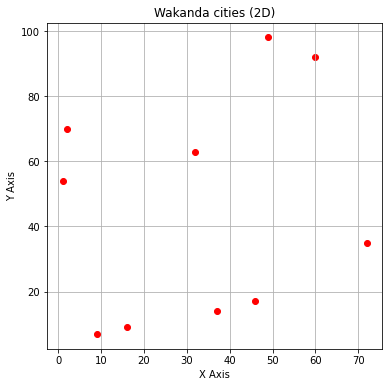

In [18]:
plt.figure(figsize=(6,6)) # Set the figure size
x_axis = np.array(cities)[:,0]
y_axis = np.array(cities)[:,1]
plt.scatter(x_axis,y_axis,color = 'r')
plt.grid()
plt.title("Wakanda cities (2D)")
plt.ylabel("Y Axis")
plt.xlabel("X Axis")

In [28]:
# Genetic Algorithm

population = initialise_population(population_size,num_cities)

best_distance = -1000000
best_chromosome = []
best_distance_history = []
distance_history = []
for i in range(num_iterations):
    # Calculate the fitness of all chromosomes in the population
    distances = calculate_fitness(population, cities, distance_function)
    # If the new population has the best distance, save it.
    if np.max(distances) > best_distance:
        best_distance = np.max(distances)
        best = np.argmax(distances)
        best_chromosome = population[best]
        best_distance_history.append(best_distance)
    distance_history.append(np.mean(distances))
    # 1. Do selection
    selected_population = selection(population, distances)
    # 2. Pair the good chromosomes 
    pairs = pairing(selected_population)
    # 3. Reproduce with cross over
    crossed_over = cross_over(pairs)
    # 4. Add some randomness with mutation
    population = mutation(crossed_over)

distances = calculate_fitness(population, cities, distance_function)
# If the new population has the best distance, save it.
if np.max(distances) > best_distance:
    best_distance = np.max(distances)
    best = np.argmax(distances)
    best_chromosome = population[best]
    best_distance_history.append(best_distance)
distance_history.append(np.mean(distances))
print("Distances: " ,distances[:5])
print("Population: ",population[:5])
print("Best chromosome: ",best_chromosome)
print("Best (shortest) distance: ",best_distance)

Distances:  [-707.0, -754.0, -731.0, -732.0, -757.0]
Population:  [[4, 9, 0, 2, 6, 3, 8, 5, 1, 7], [5, 3, 8, 6, 1, 2, 9, 4, 7, 0], [7, 3, 2, 0, 6, 8, 5, 9, 4, 1], [0, 6, 9, 5, 3, 4, 8, 2, 1, 7], [8, 7, 0, 3, 5, 4, 2, 9, 1, 6]]
Best chromosome:  [2, 8, 0, 9, 5, 6, 7, 4, 3, 1]
Best (shortest) distance:  -317.0


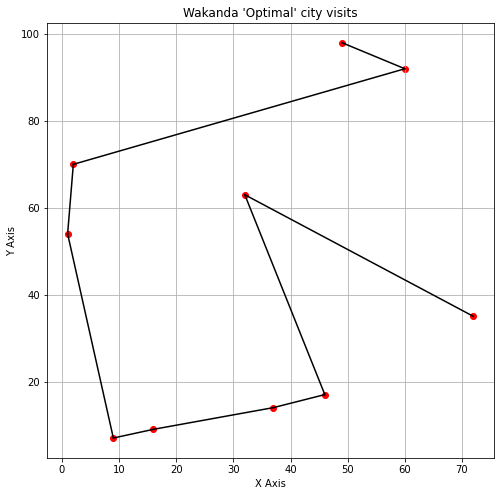

In [20]:
plt.figure(figsize=(8,8)) # Set the figure size
x_axis = np.array(cities)[:,0]
y_axis = np.array(cities)[:,1]
plt.scatter(x_axis,y_axis,color = 'r')
plt.grid()
plt.ylabel("Y Axis")
plt.xlabel("X Axis")
plt.title("Wakanda 'Optimal' city visits")
visit_order = best_chromosome
for j in range(len(visit_order)-1):
    plt.plot(x_axis[[visit_order[j],visit_order[j+1]]],y_axis[[visit_order[j],visit_order[j+1]]], color = 'k')

Text(0.5, 0, 'Sample number')

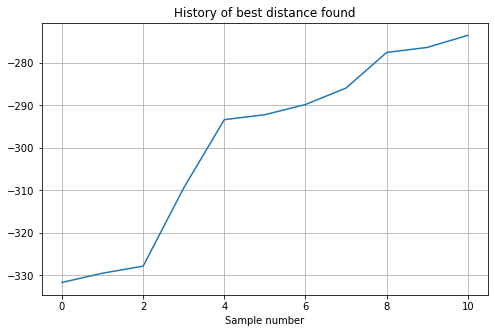

In [21]:
plt.figure(figsize= (8,5))
plt.plot(best_distance_history)
plt.title("History of best distance found")
plt.grid()
plt.xlabel("Sample number")

Text(0.5, 0, 'Sample number')

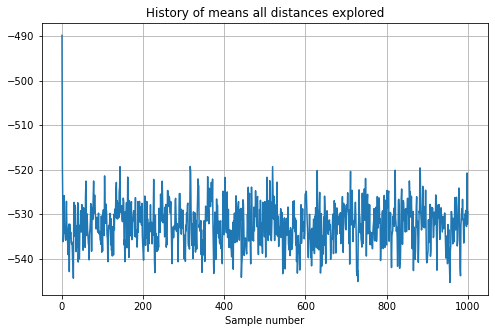

In [22]:
plt.figure(figsize= (8,5))
plt.plot(distance_history)
plt.title("History of means all distances explored")
plt.grid()
plt.xlabel("Sample number")

### 2.4 Observations [5 points]
1. What do you observe with the behaviour of the Genetic Algorithm? [2 points]
2. What happens when you increase the number of cities? [1 points]
3. What happens when you increase the populations size? [1 points]
4. How can you improve this Genetic Algorithm? [1 points]

1. We observe the evolutionary nature of the algorithm as we can see it achieves better solutions with each generation, this is ensured by the breeding and mutation algorithms which combine the best chromosomes in attempt to make a better onr. Furthermore, we observe that the algorithm often finds a good solution, but not always the best solution and that when running the solution multiple times over the same set of points, we observe that the best distance achieved is different each time. This highlights the fact the randomness allows the algorithm to avoid local minimums but also hinders the ability to settle on a global maximum.

2. When increasing the number of cities, the algorithm takes significantly longer as there are exponentially more combinations that can occur within the chromosome, this also creates a lot more "good enough" solutions that the algorithm may settle on instead of the global optimum.

3. Increasing the population size also slows down the algorithm, however it allows for more possible solutions to be explored in each generation and typically arrives at a solution in a fewer number of generations than an algorithm with a smaller population. Whilst a smaller population requires more generations, it also runs faster and so one should consider whether their contraints fall on the computation time or on the number of generations permitted when making a decision of what population size to use.

4. I would improve this algorithm by incorporating some form of elitism where the best N solutions of each generation are protected from breeding or mutation to prevent them from worsening. 

# 2.5 Extra Credit [3 points]

## 2.5.1 Manhattan distance

Can you change the distance function to now be the [Manhattan Distance](https://xlinux.nist.gov/dads/HTML/manhattanDistance.html)



In [23]:
def distance_function(cities, visit_order):
    distance = 0
    def manhattan(p1, p2):
        d = 0 
        for i in range(0,2):
            d += abs(p1[i] - p2[i])
        return d

    for i in range(1, len(visit_order)):
        distance += manhattan(cities[visit_order[i]], cities[visit_order[i-1]])
        
    return -1.0*distance

def calculate_fitness_new(population, cities,  fitness_function):
    fitness_list = []
    for i in population:
        fitness_list.append(fitness_function(cities, i))
    return fitness_list

In [24]:
# Genetic Algorithm with Manhattan Distance
best_distance = -1000000
best_chromosome = []
best_distance_history = []
distance_history = []
for i in range(num_iterations):
    # Calculate the fitness of all chromosomes in the population
    distances = calculate_fitness_new(population, cities, distance_function)
    # If the new population has the best distance, save it.
    if np.max(distances) > best_distance:
        best_distance = np.max(distances)
        best = np.argmax(distances)
        best_chromosome = population[best]
        best_distance_history.append(best_distance)
    distance_history.append(np.mean(distances))
    # 1. Do selection
    selected_population = selection(population, distances)
    # 2. Pair the good chromosomes 
    pairs = pairing(selected_population)
    # 3. Reproduce with cross over
    crossed_over = cross_over(pairs)
    # 4. Add some randomness with mutation
    population = mutation(crossed_over)

distances = calculate_fitness(population, cities, distance_function)
# If the new population has the best distance, save it.
if np.max(distances) > best_distance:
    best_distance = np.max(distances)
    best = np.argmax(distances)
    best_chromosome = population[best]
    best_distance_history.append(best_distance)
distance_history.append(np.mean(distances))
print("Distances: " ,distances[:5])
print("Population: ",population[:5])
print("Best chromosome: ",best_chromosome)
print("Best (shortest) distance: ",best_distance)

Distances:  [-782.0, -824.0, -608.0, -685.0, -673.0]
Population:  [[9, 4, 6, 3, 8, 7, 2, 1, 5, 0], [0, 6, 8, 7, 2, 1, 5, 3, 4, 9], [2, 7, 1, 8, 0, 5, 9, 4, 3, 6], [0, 3, 8, 7, 2, 6, 9, 5, 4, 1], [8, 2, 3, 4, 9, 5, 1, 0, 7, 6]]
Best chromosome:  [8, 0, 2, 5, 7, 4, 6, 9, 1, 3]
Best (shortest) distance:  -337.0


### 2.5.2 Observations

1. Can you comment on what happes with the new distance function [2 points]

NB: I changed the name of the Manhattan distance function from "distance_function_new" to "distance_function" as the Manhattan GA was using the Euclidien distance and I was unable to edit this block. 

1. At first glance it appears that the algorithm using Manhattan distance consistently performs worse than the algorithm using Euclidien distance. However this is due to the way in which the distances are calculated. If we plot two arbitrary points the Manhattan distance can only be greater than or equal to the Euclidien distance at best. And so judging the performance of the algorithms based on the "best distance" is actually incorrect since the distances themselves are calculated completely differently. When reducing the number of cities down to 3 it is very common to achieve the same "best chromosome" which shows that when the algorithm is given enough generations to evolve, the algorithms can still converge on the same solution. In a real world traveling salesman problem, the Manhattan distance may prove to be better since roads are generally structured in a grid-like fashion which is how Manhattan distance is calculated, this would likely lead to a better prediction of total distance.